In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import mat_neuron.core as matmodel

import sys
sys.path.append("../")
import cneurons as cn

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [98]:
# model parameters
matparams = np.asarray([10, 2, -0.3, 7, 15, 10, 10, 200, 5, 2], dtype='d')
matstate = np.zeros(6, dtype='d')
model_dt = 1.0

# data parameters
duration = 20000
n_assim = 2
n_test = 2

# assimilation parameters
nthreads = 8
nwalkers = 1000
nsteps = 200
nparams = 4
matparams_f = matparams[:nparams]

In [99]:
# generate data to fit
np.random.seed(1)
matmodel.random_seed(1)
data = []
I = np.random.randn(duration)
for i in range(n_assim + n_test):
    states, spikes = matmodel.predict(matstate, matparams, I, model_dt, stochastic=True)
    z = np.zeros(duration, dtype='i')
    z[spikes] = 1
    d = {"I_stim": I * 1.5,
         "duration": duration,
         "states": states,
         "spike_t": np.asarray(spikes),
         "spike_v": z,
         "lci": matmodel.log_intensity(states[:,(0,3,4)], states[:,(1,2)], matparams)}
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

178

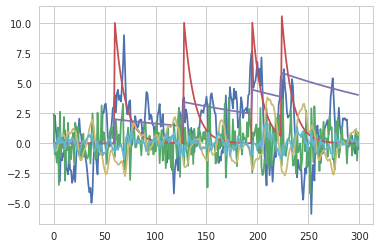

In [100]:
plt.plot(data[0]["states"][:300])
len(data[0]["spike_t"])

In [101]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos
import emcee

mat_prior = priors.joint_independent(
                [ priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                  priors.uniform(-5,   5),
                  priors.uniform( 0,  20),
                ])

# this is the local copy of the parameters that we'll update in each step
mparams = matparams.copy()

def lnpost_dyn(theta):
    """Posterior probability for dynamical parameters"""
    from mat_neuron._model import predict_voltage, predict_adaptation
    ll = mat_prior(theta)
    if not np.isfinite(ll):
        return -np.inf
    mparams[:nparams] = theta
    # precalculate impulse matrix - this is affected by beta, so it has to be in here
    Aexp = matmodel.impulse_matrix(mparams, model_dt, reduced=True)
    lp = 0
    for d in assim_data:
        Xv = predict_voltage(matstate, Aexp, mparams, d["I_stim"], model_dt)
        H = predict_adaptation(matstate, mparams, d["spike_v"], model_dt)
        lci = matmodel.log_intensity(Xv, H, mparams)
        # NB: if you get overflow errors, adjust bounds to keep lci in a reasonable range (like -100 to 100)
        lpq = np.sum(lci[d["spike_t"]]) - model_dt * np.sum(np.exp(lci))
        if lpq < -1e20:
            return -np.inf
        lp += lpq
    return ll + lp        

In [102]:
# theoretically this is as good as it can get
print(lnpost_dyn(matparams_f))
# and this is our initial state
startparams = np.asarray([[-50,-5,-5,0],[200,10,5,20]]).T
p0 = startpos.uniform_independent(nwalkers, startparams[:,0], startparams[:,1])
print(lnpost_dyn(np.median(p0, 0)))

-123812.455675
-2133.87113571


In [103]:
sampler = emcee.EnsembleSampler(nwalkers, matparams_f.size, lnpost_dyn, threads=nthreads)
tracker = utils.convergence_tracker(nsteps, nsteps/10)

for pos, prob, _ in tracker(sampler.sample(p0, iterations=nsteps, storechain=True)): 
    continue

  step      lnprob        time         ETA
------------------------------------------
    20     -2470.2     0:00:24     0:03:55
    40     -1501.3     0:00:55     0:03:47
    60     -1227.2     0:01:26     0:03:27
    80       -1151     0:01:58     0:03:02
   100     -1141.8     0:02:30     0:02:33
   120     -1140.8     0:03:02     0:02:04
   140     -1140.6     0:03:34     0:01:34
   160     -1140.6     0:04:06     0:01:03
   180     -1140.5     0:04:38     0:00:32
   200     -1140.5     0:05:09     0:00:01
   201     -1140.6     0:05:11     0:00:00


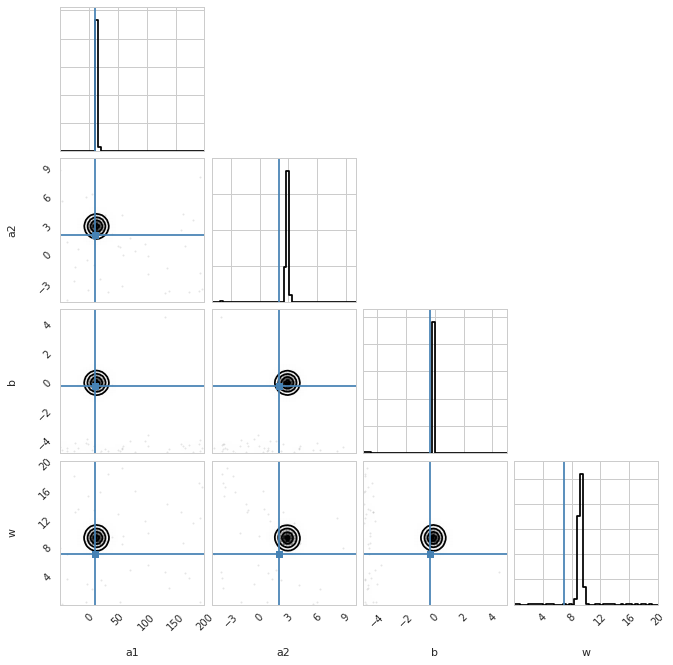

In [104]:
from corner import corner
sns.set_style("whitegrid")

matlabs = ['a1','a2','b','w']
c = corner(sampler.chain[:,-1,:],
           range=[sp for sp in startparams],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparams_f)

In [97]:
# see how well predictions line up
params_guess = np.median(pos, 0)
mparams[:nparams] = params_guess
d = assim_data[0]
Aexp = matmodel.impulse_matrix(mparams, model_dt, reduced=True)
Y, S = matmodel.predict(matstate, mparams, d["I_stim"], model_dt, stochastic=True)
Xv = matmodel.predict_voltage(matstate, mparams, d["I_stim"], model_dt)
H = matmodel.predict_adaptation(matstate, mparams, d["spike_v"], model_dt)
lci_guess = matmodel.log_intensity(Xv, H, mparams)

print(params_guess)
print(matparams_f)
print(len(S), len(d["spike_t"]))

[ 9.1838891   2.04806331 -0.24332172  6.78057049]
[ 10.    2.   -0.3   7. ]
168 178


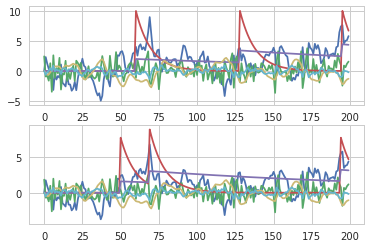

In [73]:
%matplotlib inline
plt.subplot(211)
plt.plot(d["states"][:200])
plt.subplot(212)
plt.plot(Y[:200])